# Monte Carlo simulation to analyse stock portfolio performance

The Monte Carlo method is a computational technique that relies on repeated random sampling to obtain results. It is particularly useful for problems involving uncertainty. This involves running the simulation many times with different random inputs and analyzing the results to estimate an outcome.

Even though, in reality, stocks are difficult to model, even with more random variables and a non-normal distribution, we can still use Monte Carlo simulations effectively. This is because by randomizing the input and using a large number of simulation runs, we can hope to converge to a good solution.


We will simulate a portfolio's performance over 100 days. First, we will take finance data from stooq and use pandas to read it in.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

Then we create a function which will retrieve and manipulate the stock data into our desired format. We only get the "Close" column values. We also restrict the dates of data to a range.

We return the mean returns of each stock per day over the time period, and the covariance matrix.

In [8]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_stooq(stocks, start, end)
    stockData = stockData["Close"]
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

I chose a simple list of stocks which can be extended. The model looks at data over the past 300 days. 

The covariance matrix looks at how the stocks move relative to eachother. Positive values means that the stocks tend to increase together, and vice versa. A value close to 0 indicates that they are unrelated.

In [9]:
stockList = ["AAPL", "MSFT", "GOOGL"]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(stockList, startDate, endDate)
print(meanReturns)

Symbols
AAPL    -0.001664
MSFT     0.000062
GOOGL   -0.000108
dtype: float64


Then we set up some of the basic values we need for the simulation.

<li>The weights represent how much of our portfolio is invested in each stock, and is randomly generated.</li>
<li>Shape defines the number of rows and columns in the np array. the full() method fills it with a default value.</li>
<li>We will run 100 simulations that model 100 days into the future.</li>
<li>meanM is a matrix of expected daily returns over the 100 days.</li>
<li>We also create a matrix to store our simulated values.</li>

In [10]:
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)
print(weights)

numSimulations = 100
timeframe = 100

meanM = np.full(shape=(timeframe, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolioSimulations = np.full(shape=(timeframe, numSimulations), fill_value=0.0)
initialPortfolio = 10000

[0.15925085 0.09931826 0.74143089]


We model it as a standard multivariate normal distribution (Z). This means that the mean = 0 and $\sigma$ = 1.

L is the lower triangular matrix converted from the covariance matrix, using the Cholesky decomposition method.

In the next step, we use L and Z to kind of simulate how the real world affects the stock prices, by looking at randomness (Z) and how the stock prices affect eachother (L). It tries to match real world risk and correlation.

In the final line, we calculate the weighted sums of the returns to see how the portfolio changes overall. We update column m in the matrix with our calculated value.



In [11]:
for m in range(0, numSimulations):
    Z = np.random.normal(size=(timeframe, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolioSimulations[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1) * initialPortfolio

Finally we can plot the simulations of the portfolio over the time period.

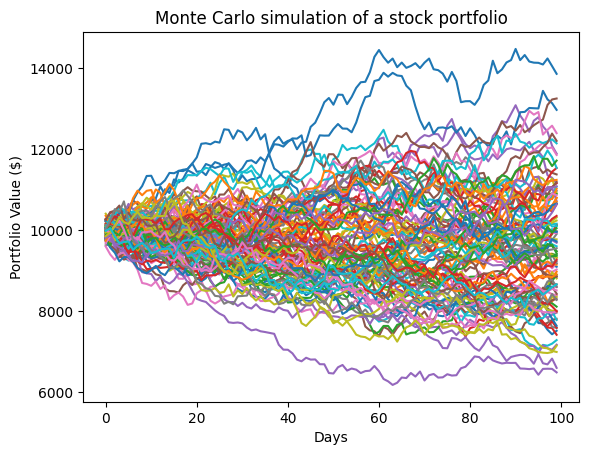

In [12]:
plt.plot(portfolioSimulations)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("Monte Carlo simulation of a stock portfolio")
plt.show()